In [2]:
import numpy as np
from matplotlib import pyplot as plt

import matplotlib.cm as cm
import matplotlib.animation as animation

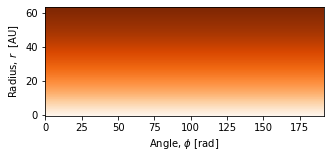

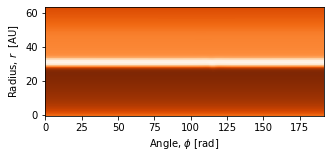

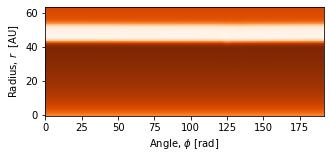

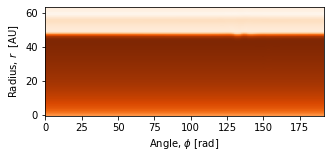

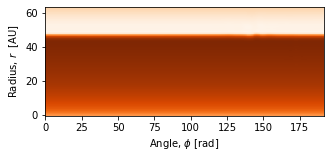

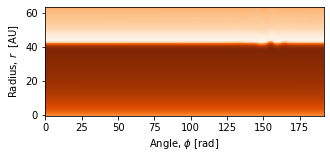

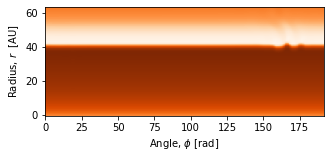

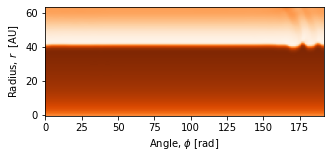

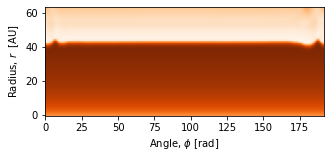

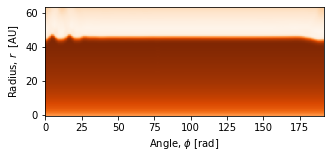

In [3]:
run_name =  'cdi_0043'
n = 10
data_filenames=[]
for i in range(0,n):
    data_filenames.append('/Users/jsn/landing/data/{}/gasdens{}.dat'.format(run_name, i))
    
power = 6
for i in range(n):
    fig,ax = plt.subplots(figsize=(5,2))
    rho = np.fromfile(data_filenames[i]).reshape(2**power,3*2**power)
    im = ax.imshow(np.log10(rho),origin='lower',cmap=cm.Oranges_r, aspect='auto')
    ax.set_xlabel('Angle, $\phi$ [rad]')
    ax.set_ylabel('Radius, $r$  [AU]')
    #fig.colorbar(im)

    #plt.savefig('1_2_resonance_runaway_density.pdf', bbox_inches='tight')

    plt.show()

/var/folders/6y/p7j56dj17hj87w_r01qjgv480000gn/T/ipykernel_2779/2403475855.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X,Y, rho, cmap=cm.Oranges_r)


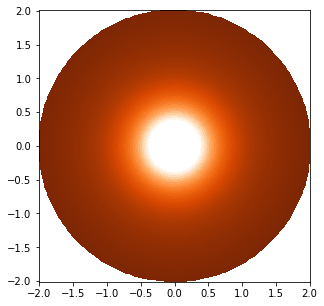

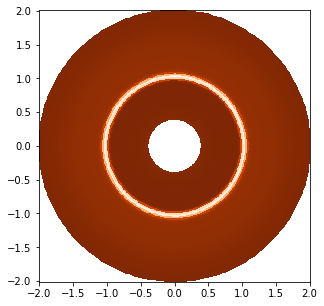

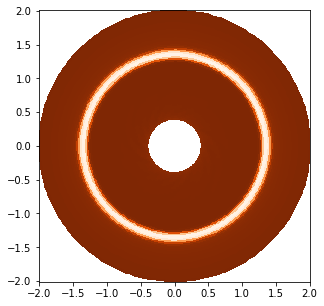

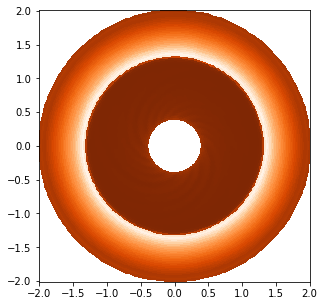

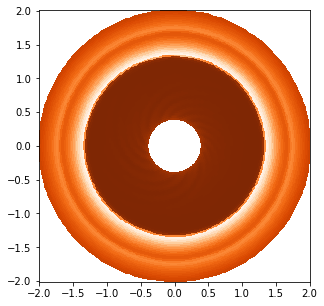

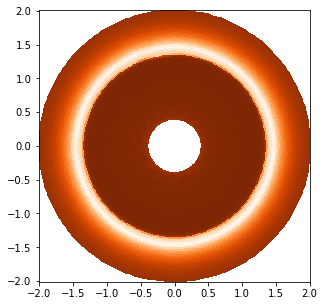

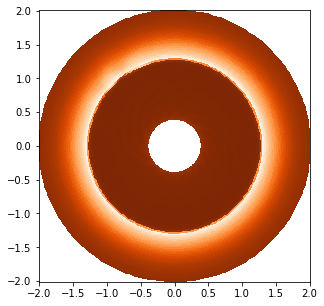

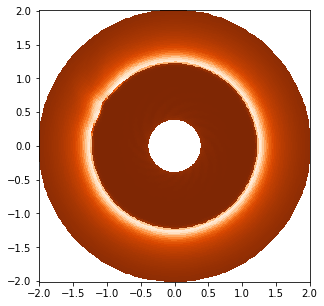

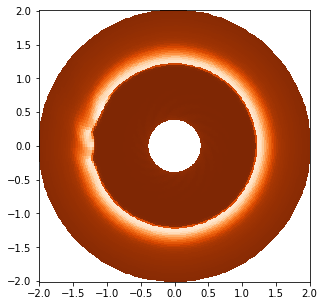

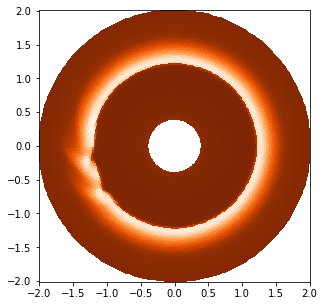

In [10]:
run_name=  'cdi_0049'
n = 10
data_filenames=[]
for i in range(0,n):
    data_filenames.append('/Users/jsn/landing/data/{}/gasdens{}.dat'.format(run_name, i))
    
power=6
for i in range(n):
    rho = np.fromfile(data_filenames[i]).reshape(2**power,3*(2**power))
    phi = np.linspace(-np.pi, np.pi, 3*(2**power))
    r = np.linspace(0.4, 2, 2**power)
    PHI, R = np.meshgrid(phi, r)
    X = R*np.cos(PHI)
    Y = R*np.sin(PHI)

    fig,ax = plt.subplots(figsize=(5,5))

    ax.pcolormesh(X,Y, rho, cmap=cm.Oranges_r)
    ax.set_aspect("equal")

    plt.show()
